Start with a simple multi-stage autoencoder.

Use pRELU since it should be invertible

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist


In [2]:

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [3]:
def create_model():
    input_img = keras.Input(shape=(784,))
    encoded = layers.Dense(128)(input_img)
    encoded = layers.PReLU()(encoded)
    encoded = layers.Dense(64)(encoded)
    encoded = layers.PReLU()(encoded)
    encoded = layers.Dense(32)(encoded)
    encoded = layers.PReLU()(encoded)

    decoded = layers.Dense(64)(encoded)
    encoded = layers.PReLU()(encoded)
    decoded = layers.Dense(128)(decoded)
    encoded = layers.PReLU()(encoded)
    decoded = layers.Dense(784, activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    return autoencoder


In [4]:
model = create_model()
model.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True)
prelu = []
for layer in model.layers:
    if 'p_re_lu' in layer.name:
        prelu.append(layer)
print(prelu)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 p_re_lu (PReLU)             (None, 128)               128       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 p_re_lu_1 (PReLU)           (None, 64)                64        
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 p_re_lu_2 (PReLU)           (None, 32)                32    

In [5]:
for p in prelu:
    print(p.trainable_weights)

[<tf.Variable 'p_re_lu/alpha:0' shape=(128,) dtype=float32, numpy=
array([ 9.71000548e-03,  7.32508302e-02,  2.85959523e-02, -3.82519588e-02,
        2.90668815e-01,  1.69363156e-01,  2.45097190e-01,  6.92224801e-02,
       -5.32902889e-02,  9.22408514e-03,  1.10214159e-01,  4.06620741e-01,
        1.24493331e-01,  3.46499383e-02,  3.02098729e-02,  4.21229675e-02,
        2.98868477e-01,  2.22231708e-02,  1.12229533e-01,  2.89825916e-01,
        3.25130165e-01, -5.59885390e-02,  1.35369763e-01,  1.30249247e-01,
       -1.26103759e-02,  3.42662275e-01, -2.90157795e-02, -9.65612009e-02,
        1.44173875e-01,  4.54036929e-02,  1.65743247e-01,  6.32910952e-02,
        2.11370625e-02,  2.11678296e-01,  1.25232348e-02,  1.32398292e-01,
        6.15807056e-01,  1.80929542e-01,  2.34870955e-01, -4.58888300e-02,
        1.54503629e-01, -8.20528995e-03,  1.62208937e-02, -6.45974725e-02,
        6.33314773e-02,  2.06263199e-01, -2.18371954e-02,  2.42061242e-01,
        2.03945354e-01, -1.226644

In [6]:
class TiedDense(layers.Layer):
    def __init__(self, master_layer):
        super(TiedDense, self).__init__()
        self.master_layer = master_layer

    def build(self, input_shape):
        # do not train weights or bias from master_layer, they are read-only
        self.params = []
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        W = self.master_layer._trainable_weights[0]
        b = self.master_layer._trainable_weights[1]
        w = tf.transpose(W)
        return tf.matmul(inputs - b, w)
    

In [7]:

class TiedPReLU(layers.Layer):
    def __init__(self, master_layer):
        super(TiedPReLU, self).__init__()
        self.master_layer = master_layer

    def build(self, input_shape):
        # do not train weights or bias from master_layer, they are read-only
        self.params = []

    def call(self, inputs):
        alpha = 1/(self.master_layer.alpha + 0.00001)
        pos = keras.backend.relu(inputs)
        neg = -alpha * keras.backend.relu(-inputs)
        return pos + neg


In [18]:
kernel_init='he_normal'
paper_init=keras.initializers.Constant(0.25)
def create_palindromic_model():
    input_img = keras.Input(shape=(784,))
    a = layers.Dense(128, kernel_initializer=kernel_init)
    encoded = a(input_img)
    a_p = layers.PReLU(alpha_initializer=paper_init)
    encoded = a_p(encoded)
    # encoded = layers.Dropout(0.2)(encoded)
    b = layers.Dense(64, kernel_initializer=kernel_init)
    encoded = b(encoded)
    b_p = layers.PReLU(alpha_initializer=paper_init)
    encoded = b_p(encoded)
    c = layers.Dense(32, kernel_initializer=kernel_init)
    encoded = c(encoded)
    c_p = layers.PReLU(alpha_initializer=paper_init)
    encoded = c_p(encoded)

    embedding = encoded

    decoded = TiedPReLU(c_p)(embedding)
    decoded = TiedDense(c)(decoded)
    decoded = TiedPReLU(b_p)(decoded)
    decoded = TiedDense(b)(decoded)
    decoded = TiedPReLU(a_p)(decoded)
    decoded = TiedDense(a)(decoded)
    decoded = layers.Activation(activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    return autoencoder


In [19]:
num_epochs = 100
autoencoder = create_palindromic_model()

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_15 (Dense)            (None, 128)               100480    
                                                                 
 p_re_lu_14 (PReLU)          (None, 128)               128       
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 p_re_lu_15 (PReLU)          (None, 64)                64        
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 p_re_lu_16 (PReLU)          (None, 32)                32  

In [20]:

predicted_imgs = autoencoder.predict(x_test)
# decoded_imgs = autoencoder.predict(encoded_imgs)

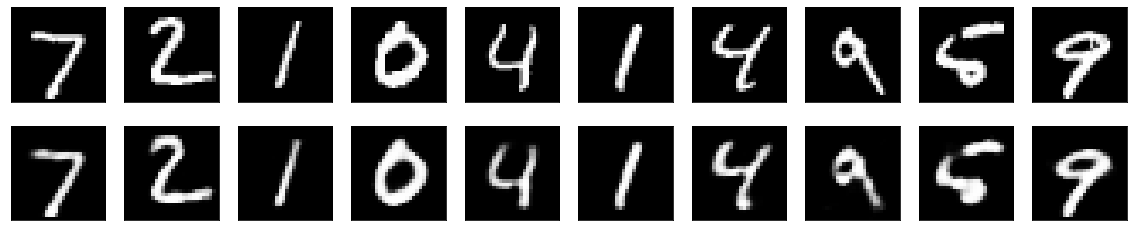

In [21]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
